In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Conv3D,MaxPooling3D,UpSampling3D,concatenate,Conv3DTranspose,BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation, Concatenate
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from PIL import Image 
from read_write_mrc import read_mrc, write_mrc
import skimage 
import torch 
import torchvision as transforms 
from PIL import Image 
import os 
import cv2

In [3]:
device_name = tf.test.gpu_device_name()

if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
    
print('Found GPU at: {}'.format(device_name))


# print(tf.test.is_gpu_available())
print(tf.test.is_built_with_cuda())
print(tf.test.is_built_with_gpu_support())


Found GPU at: /device:GPU:0
True
True


2023-02-27 19:45:47.591370: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:5b:00.0 name: NVIDIA GeForce RTX 3090 computeCapability: 8.6
coreClock: 1.695GHz coreCount: 82 deviceMemorySize: 23.66GiB deviceMemoryBandwidth: 871.81GiB/s
2023-02-27 19:45:47.591522: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2023-02-27 19:45:47.591558: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-02-27 19:45:47.591587: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2023-02-27 19:45:47.591614: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2023-02-27 19:45:47.591641: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcu

In [4]:
from tensorflow.keras import backend as K

def dice_coefficient(y_true, y_pred):
    smoothing_factor = 1
    flat_y_true = K.flatten(y_true)
    flat_y_pred = K.flatten(y_pred)
    return (2. * K.sum(flat_y_true * flat_y_pred) + smoothing_factor) / (K.sum(flat_y_true) + K.sum(flat_y_pred) + smoothing_factor)

def dice_coefficient_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

In [5]:
def conv_block(input, num_filters):
    x = Conv3D(num_filters, 3, padding = "same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    x = Conv3D(num_filters, 3, padding = "same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    return x



def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPooling3D((2,2,2))(x)
    return x,p


def decoder_block(input, skip_features ,num_filters):
    x= Conv3DTranspose(num_filters, (2,2,2), strides = 2, padding = "same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x
                       
                       
                       
                       
def UNet(input_shape, num_classes):
    inputs = Input(input_shape)
    
    
    s1,p1 = encoder_block(inputs, 8)
    s2,p2 = encoder_block(p1, 16)
    s3,p3 = encoder_block(p2, 32)
    s4,p4 = encoder_block(p3, 64)
    # s5,p5 = encoder_block(p4, 512)
    
    b1 = conv_block(p4, 128)
    
    # d1 = decoder_block(b1, s5, 512)
    d2 = decoder_block(b1, s4, 64)
    d3 = decoder_block(d2, s3, 32)
    d4 = decoder_block(d3, s2, 16)
    d5 = decoder_block(d4, s1, 8)
    
    if num_classes == 1: # Binary segmentaion
        activation = "sigmoid"
        
    else:
        activation = "softmax"
        
    outputs = Conv3D(num_classes, 1 , padding = "same", activation = activation)(d5)
    
    model = Model(inputs, outputs, name ="U-Net")
    
    return model 
        

In [6]:
img_directory = 'slices/images'
mask_directory = 'slices/masks'



img_name_list = os.listdir(img_directory)
mask_name_list =  os.listdir(mask_directory)


img_name_list.sort()
mask_name_list.sort()

# num_images = len(img_name)

X_list = []
Y_list = []

zeros = 0
nonzeros= 0

for img_name,mask_name in zip(img_name_list, mask_name_list):
    # assert str(img_name[0:-4]+str('_labels.mrc')) == str(mask_name), "Mask doesn't match to image"
    
    assert len(img_name_list) == len(mask_name_list), "Number of images != number of masks"
    
    
    img = read_mrc(os.path.join(img_directory, img_name))
    mask = read_mrc(os.path.join(mask_directory, mask_name))
    
    mask = np.where((mask == 5), np.ones(mask.shape), np.zeros(mask.shape))
    
    assert img.shape == mask.shape, "Mask shape does not match to image shape."
    
    assert img.shape == (64,704,704), "Wrong shape for image"
    assert mask.shape == (64,704,704), "Wrong shape for mask"

    
    if( ( np.count_nonzero(img)==0 )  or  ( np.count_nonzero(mask) == 0)  ):
        continue
        
    X_list.append(img)
    Y_list.append(mask)

In [7]:
print(len(X_list))
print(len(Y_list))

37
37


In [8]:
X = np.asarray(X_list)
Y = np.asarray(Y_list)

In [9]:
print(X.shape)
print(Y.shape)

(37, 64, 704, 704)
(37, 64, 704, 704)


In [10]:
train_img = np.stack((X,)*1, axis = -1)
train_mask = np.expand_dims(Y, axis = 4)

In [11]:
print(train_img.shape)
print(train_mask.shape)

(37, 64, 704, 704, 1)
(37, 64, 704, 704, 1)


In [12]:
num_classes = 2

# np.unique(train_mask)

train_mask_cat = to_categorical(train_mask , num_classes = num_classes)

In [13]:
print(train_img.shape)
print(train_mask_cat.shape)

(37, 64, 704, 704, 1)
(37, 64, 704, 704, 2)


In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_img, train_mask_cat, test_size = 0.27, random_state =0 )

In [15]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(27, 64, 704, 704, 1)
(27, 64, 704, 704, 2)
(10, 64, 704, 704, 1)
(10, 64, 704, 704, 2)


In [16]:
channels = 1
LR= 0.001
optim= tf.keras.optimizers.Adam(LR)

In [17]:
device_name = tf.test.gpu_device_name()

if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
    
print('Found GPU at: {}'.format(device_name))

print(tf.test.is_gpu_available())
print(tf.test.is_built_with_cuda())
print(tf.test.is_built_with_gpu_support())

Found GPU at: /device:GPU:0
True
True
True


2023-02-27 19:46:56.596715: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:5b:00.0 name: NVIDIA GeForce RTX 3090 computeCapability: 8.6
coreClock: 1.695GHz coreCount: 82 deviceMemorySize: 23.66GiB deviceMemoryBandwidth: 871.81GiB/s
2023-02-27 19:46:56.596864: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2023-02-27 19:46:56.596900: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-02-27 19:46:56.596928: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2023-02-27 19:46:56.596955: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2023-02-27 19:46:56.596982: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcu

In [18]:
model = UNet((64,704,704,1), num_classes = 2)

model.compile( optimizer = optim , loss = dice_coefficient_loss, metrics = dice_coefficient )

print(model.summary())

2023-02-27 19:47:03.513697: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:5b:00.0 name: NVIDIA GeForce RTX 3090 computeCapability: 8.6
coreClock: 1.695GHz coreCount: 82 deviceMemorySize: 23.66GiB deviceMemoryBandwidth: 871.81GiB/s
2023-02-27 19:47:03.513835: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2023-02-27 19:47:03.513863: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-02-27 19:47:03.513885: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2023-02-27 19:47:03.513906: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2023-02-27 19:47:03.513926: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcu

Model: "U-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 704, 704 0                                            
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, 64, 704, 704, 224         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 64, 704, 704, 32          conv3d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 64, 704, 704, 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [19]:
print(model.input_shape)
print(model.output_shape)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(None, 64, 704, 704, 1)
(None, 64, 704, 704, 2)
(27, 64, 704, 704, 1)
(27, 64, 704, 704, 2)
(10, 64, 704, 704, 1)
(10, 64, 704, 704, 2)


In [20]:
del X

In [21]:
del Y

In [22]:
del train_img

In [23]:
del train_mask

In [24]:
history = model.fit(X_train, y_train, batch_size = 1 , epochs = 15  , validation_data = (X_test, y_test))

Epoch 1/15


2023-02-27 19:47:22.395899: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2023-02-27 19:50:05.531919: W tensorflow/stream_executor/gpu/asm_compiler.cc:81] Running ptxas --version returned 256
2023-02-27 19:50:06.652183: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-02-27 19:50:19.424462: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10


27/27 [==============================] - 81s 3s/step - loss: 0.3587 - dice_coefficient: 0.6413 - val_loss: 0.4029 - val_dice_coefficient: 0.5971
Epoch 2/15
27/27 [==============================] - 106s 4s/step - loss: 0.2125 - dice_coefficient: 0.7875 - val_loss: 0.1258 - val_dice_coefficient: 0.8742
Epoch 3/15
27/27 [==============================] - 125s 5s/step - loss: 0.1603 - dice_coefficient: 0.8397 - val_loss: 0.1281 - val_dice_coefficient: 0.8719
Epoch 4/15
27/27 [==============================] - 139s 5s/step - loss: 0.1320 - dice_coefficient: 0.8680 - val_loss: 0.1482 - val_dice_coefficient: 0.8518
Epoch 5/15
27/27 [==============================] - 141s 5s/step - loss: 0.1100 - dice_coefficient: 0.8900 - val_loss: 0.1149 - val_dice_coefficient: 0.8851
Epoch 6/15
27/27 [==============================] - 149s 6s/step - loss: 0.0925 - dice_coefficient: 0.9075 - val_loss: 0.1292 - val_dice_coefficient: 0.8708
Epoch 7/15
27/27 [==============================] - 151s 6s/step - los

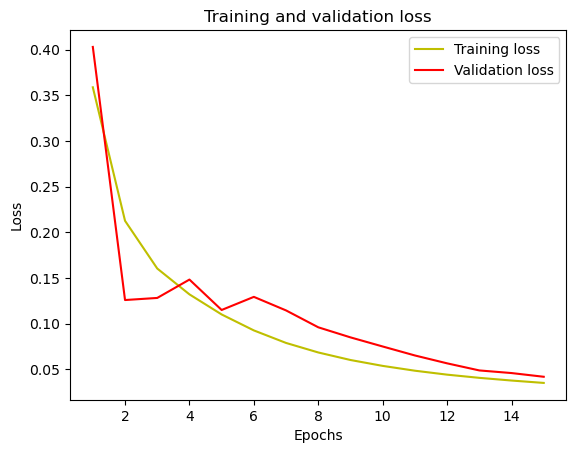

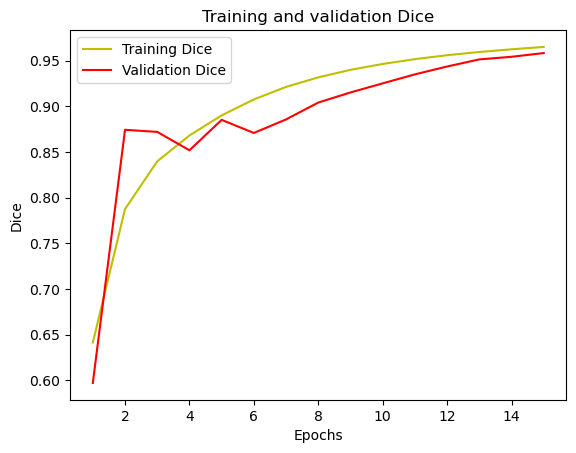

In [25]:
###
#plot the training and validation IoU and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['dice_coefficient']
val_acc = history.history['val_dice_coefficient']

plt.plot(epochs, acc, 'y', label='Training Dice')
plt.plot(epochs, val_acc, 'r', label='Validation Dice')
plt.title('Training and validation Dice')
plt.xlabel('Epochs')
plt.ylabel('Dice')
plt.legend()
plt.show()

In [25]:
model.save('model/test_model.h5')

In [2]:
from tensorflow.keras.models import load_model 

In [ ]:
my_model = load_model('model/test_model.h5')

2023-02-27 19:43:15.003701: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2023-02-27 19:43:15.057429: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:5b:00.0 name: NVIDIA GeForce RTX 3090 computeCapability: 8.6
coreClock: 1.695GHz coreCount: 82 deviceMemorySize: 23.66GiB deviceMemoryBandwidth: 871.81GiB/s
2023-02-27 19:43:15.057909: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2023-02-27 19:43:15.061947: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-02-27 19:43:15.065474: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2023-02-27 19:43:15.066092: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuran

In [27]:




img_directory = 'test/images'
mask_directory = 'test/masks'



img_name_list = os.listdir(img_directory)
mask_name_list =  os.listdir(mask_directory)


img_name_list.sort()
mask_name_list.sort()

# num_images = len(img_name)

X_list = []
Y_list = []

zeros = 0
nonzeros= 0

for img_name,mask_name in zip(img_name_list, mask_name_list):
    # assert str(img_name[0:-4]+str('_labels.mrc')) == str(mask_name), "Mask doesn't match to image"
    
    assert len(img_name_list) == len(mask_name_list), "Number of images != number of masks"
    
    
    img = read_mrc(os.path.join(img_directory, img_name))
    mask = read_mrc(os.path.join(mask_directory, mask_name))
    
    mask = np.where((mask == 5), np.ones(mask.shape), np.zeros(mask.shape))
    
    assert img.shape == mask.shape, "Mask shape does not match to image shape."
    
    assert img.shape == (64,704,704), "Wrong shape for image"
    assert mask.shape == (64,704,704), "Wrong shape for mask"

    
    if( ( np.count_nonzero(img)==0 )  or  ( np.count_nonzero(mask) == 0)  ):
        continue
        
    X_list.append(img)
    Y_list.append(mask)



In [47]:
X = np.asarray(X_list[1:3])
Y = np.asarray(Y_list[1:3])

In [48]:
test_img = np.stack((X,)*1, axis = -1)
test_mask = np.expand_dims(Y, axis = 4)

In [49]:
num_classes = 2

# np.unique(train_mask)

train_mask_cat = to_categorical(test_mask , num_classes = num_classes)

In [50]:
y_true = train_mask_cat

In [51]:
x_test = test_img

2023-02-27 22:31:56.660238: W tensorflow/core/common_runtime/bfc_allocator.cc:434] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.89GiB (rounded to 2030043136)
Current allocation summary follows.
2023-02-27 22:31:56.660327: I tensorflow/core/common_runtime/bfc_allocator.cc:934] BFCAllocator dump for GPU_0_bfc
2023-02-27 22:31:56.660354: I tensorflow/core/common_runtime/bfc_allocator.cc:941] Bin (256): 	Total Chunks: 306, Chunks in use: 306. 76.5KiB allocated for chunks. 76.5KiB in use in bin. 22.7KiB client-requested in use in bin.
2023-02-27 22:31:56.660381: I tensorflow/core/common_runtime/bfc_allocator.cc:941] Bin (512): 	Total Chunks: 22, Chunks in use: 22. 11.2KiB allocated for chunks. 11.2KiB in use in bin. 11.0KiB client-requested in use in bin.
2023-02-27 22:31:56.660395: I tensorflow/core/common_runtime/bfc_allocator.cc:941] Bin (1024): 	Total Chunks: 4, Chunks in use: 4. 4.2KiB allocated for chunks. 4.2KiB in use in bin. 3.5KiB client-requested in use in bin.
20

ResourceExhaustedError: OOM when allocating tensor with shape[2,8,64,704,704] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Conv3D]